Do the cell type mapping with both standard and Nanostring version of cell2location.

Load libraries and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import isctools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

In [5]:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

Make sure we have the same genes in reference and spatial data:

In [6]:
wta_genes = np.asarray(adata_wta.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in meanExpression_sc.index] 
adata_wta = adata_wta[:,[adata_wta.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata_wta.var_names))]]
meanExpression_sc = meanExpression_sc.reindex(index = common_genes)

Fit each slide 00MU:

In [7]:
adata_wta = adata_wta[[adata_wta.obs['slide'][i] == '00MU' for i in range(len(adata_wta.obs['slide']))]]

In [8]:
counts_geneProbes = np.asarray(adata_wta[:,np.array(adata_wta.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata_wta[:,np.array(adata_wta.var =='NegProbe-WTX').squeeze()].X)
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1)

celltypes = meanExpression_sc.keys()
meanExpression_sc = np.asarray(meanExpression_sc)

In [9]:
celltypes

Index(['End', 'ExDp1', 'ExDp2', 'ExM', 'ExM-U', 'ExN', 'InCGE', 'InMGE', 'IP',
       'Mic', 'OPC', 'oRG', 'Per', 'PgG2M', 'PgS', 'vRG'],
      dtype='object')

In [10]:
models = list()

models.append(isctools.ProbeCounts_CoLocationModel_NegBinom(
            cell_state_mat = meanExpression_sc,
            X_data = counts_geneProbes,
            data_type='float32',
            n_iter=20000,
            learning_rate=0.001,
            fact_names=celltypes,
            gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
            cell_number_prior={'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 50},
            cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))

models.append(isctools.ProbeCounts_CoLocationModel_Poisson(
            cell_state_mat = meanExpression_sc,
            X_data = counts_geneProbes,
            Y_data = counts_negativeProbes,
            data_type='float32',
            n_iter=20000,
            learning_rate=0.001,
            fact_names=celltypes,
            gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
            cell_number_prior={'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 50},
            cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))


0


Average Loss = inf: 100%|██████████| 50000/50000 [03:39<00:00, 228.25it/s]
Finished [100%]: Average Loss = nan


Average Loss = inf: 100%|██████████| 50000/50000 [03:43<00:00, 223.45it/s]
Finished [100%]: Average Loss = nan


1


Average Loss = 5.8435e+06: 100%|██████████| 50000/50000 [03:28<00:00, 239.59it/s]
Finished [100%]: Average Loss = 5.8435e+06


Average Loss = 5.8436e+06: 100%|██████████| 50000/50000 [03:23<00:00, 245.60it/s]
Finished [100%]: Average Loss = 5.8436e+06


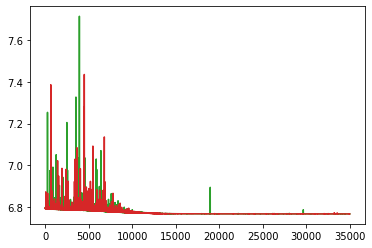

In [11]:
for i in range(2):
    print(i)
    models[i].fit_advi_iterative(n_iter = 50000, learning_rate = 0.001, n=2, method='advi')

Plot history and stability:

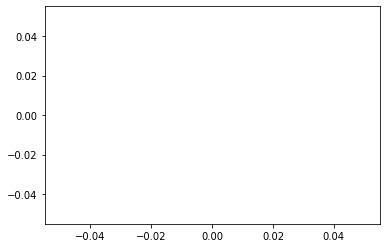

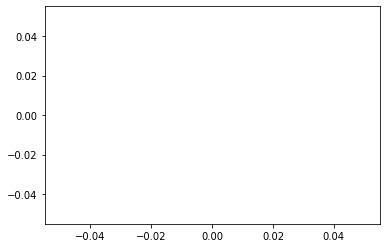

None


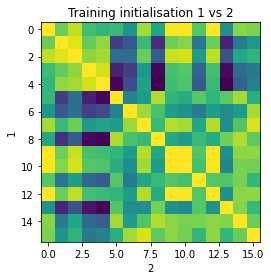

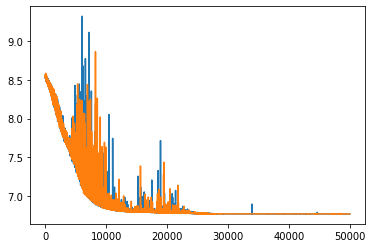

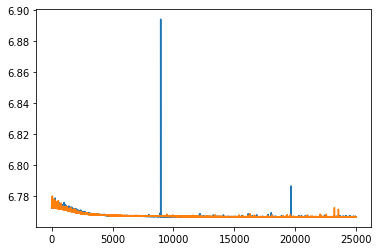

None


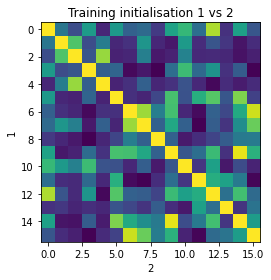

In [12]:
for i in range(2):
    models[i].plot_history()
    plt.show()
    models[i].plot_history(25000)
    plt.show()
    models[i].evaluate_stability()
    plt.show()

Evaluate posterior and plot it vs data:

In [13]:
for i in range(2):
    print(slides[i])
    models[i].sample_posterior(node='all', n_samples=1000, save_samples=False);
    isctools.ProbeCounts_CoLocationModel_Poisson.compute_expected(models[i])
    models[i].plot_posterior_mu_vs_data()
    plt.show()

NameError: name 'slides' is not defined

Calculate the spot factors:

In [ ]:
for i in range(2):
    models[i].sample2df(node_name='spot_factors')

Save models just in case:

In [ ]:
pickle.dump(models, file = open( "0_publication_figures_scripts/models_Comparison.p", "wb" ))

Overview plot of the cell locations in the 19pcw and 14pcw samples:

In [ ]:
subset_plot = list()
for i in range(len(slides)):
    subset_plot.append([adata_slide[i].obs['AOI_type'][j] == 'Geometric' and
                        adata_slide[i].obs['Radial_position'][j] == 2 for j in range(len(adata_slide[i].obs['AOI_type']))])

In [ ]:
i = 1
j = 1
models[i].spot_factors_df.iloc[:,j]

We use the colour code that we use for all figures:

In [ ]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))

In [ ]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.15
power = 1

labels = ('19pcw_void', '19pcw_1', '19pcw_2', '14pcw_1')

for i in (1,2,3):
    
    celltypesForPlot = np.repeat(models[i].fact_names,sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]] for j in range(len(models[i].fact_names))])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (12,8))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,100,500,1000,3000,6000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Total Number", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_TotalNumber_' + labels[i] + '.pdf')
    

Now make the same plot but with proportions:

In [ ]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 25
power = 2

labels = ('19pcw_void', '19pcw_1', '19pcw_2', '14pcw_1')

for i in (1,2,3):
    
    celltypesForPlot = np.repeat(models[i].fact_names,sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/sum(models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]])
                              for j in range(len(models[i].fact_names))])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (12,8))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,0.1,0.25,0.5,0.75,1]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Proportion across \n cortical depth", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_ProportionsAcrossCorticalDepth' + labels[i] + '.pdf')